# DSPy with Amazon Bedrock - Embeddings, Multi-Modal RAG

This notebook explores how to leverage [DSPy](https://github.com/stanfordnlp/dspy) with Amazon Bedrock LLMs and Embedding models. Specifically :
- Simple module - Explores building a module with SQUAD dataset
- Advanced module- This section builds on the concepts from the first use case and adds more functionalities through DSPy. This takes CAUD dataset, splits the legal contracts into smaller sections and stores in a local vector store. To compare the predicted answer with the golden set answer, we will build another DSPy module and use LLM to weigh in if they are semantically similar.
- Multi-modal RAG (Retrieval-Augmented Generation) - Allowing users to supply both text and images as input for querying, comparing, and analyzing data all with DSPy module.

In [ ]:
!pip uninstall dspy-ai -y

In [ ]:
!pip install boto3 --upgrade

In [ ]:
!pip install git+https://github.com/stanfordnlp/dspy.git

In [ ]:
!pip install chromadb

In [ ]:
!pip install qdrant-client

In [ ]:
!pip install datasets

In [ ]:
!pip install sentence_transformers

## Restart Kernel

In [ ]:
#Restart Kernel after the installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from dspy_ext import *
from chromadb_ext import *

In [2]:
import json, os, sys
import io, base64
import pathlib
from PIL import Image as PILImage
import boto3
import sagemaker

session = boto3.Session()
sagemaker_session = sagemaker.Session()
studio_region = sagemaker_session.boto_region_name 
bedrock = session.client("bedrock", region_name=studio_region)
br = session.client("bedrock-runtime", region_name=studio_region)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
claude_sonnet_model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
clade_haiku_model_id = "anthropic.claude-3-haiku-20240307-v1:0"
titan_embed_model_id = "amazon.titan-embed-image-v1"

In [4]:
import IPython
def show_img(image_path):
    IPython.display.display(IPython.display.Image(filename=image_path,width=600,height=600))
def print_md(txt):
    IPython.display.display(IPython.display.Markdown(txt))

In [42]:
import dspy
dsp_bedrock = dspy.Bedrock(region_name=studio_region)
claude_sonnet = dspy.AWSAnthropic(dsp_bedrock,claude_sonnet_model_id,max_new_tokens=4096,max_tokens=4096)
claude_haiku = dspy.AWSAnthropic(dsp_bedrock,clade_haiku_model_id,max_new_tokens=4096,max_tokens=4096)

In [43]:
dspy.settings.configure(lm=claude_sonnet, trace=[], temperature=0.7)

## Building a simple DSPy module with SQUAD dataset
Here we will use SQUAD dataset and filter for 'Solar_energy' category items. SQUAD dataset provides Context, Question and the LLM is expected provide an answer based on the supplied context. 

In [7]:
solar_ds = SolarEnergyQA()

In [8]:
trainset = [e.with_inputs('question','context') for e in solar_ds.train[0:50]] 
testset = [e.with_inputs('question','context') for e in solar_ds.test[0:10]] 
len(solar_ds.train), len(solar_ds.test), len(trainset), len(testset)

(225, 25, 50, 10)

In [9]:
import random
def get_rnd_squad(ds):
    rcrd = random.randint(0,len(ds) -1)
    context = ds[rcrd]["context"]
    question = ds[rcrd]["question"]
    answer = ds[rcrd]["answer"]
    answer_start = ds[rcrd]["answer_start"]
    return context,question,answer,answer_start

def random_query(prog,ds):
    c,q,a,a_s = get_rnd_squad(ds)
    print(f"context: {c} \nquestion: {q} \ngolden ans: {a} \n")
    return prog.forward(context=c,question=q,max_tokens=4096)

In [10]:
c,q,a,a_s = get_rnd_squad(trainset)
print(f"context: {c} \nquestion: {q} \ngolden ans: {a}")

context: Solar power is the conversion of sunlight into electricity, either directly using photovoltaics (PV), or indirectly using concentrated solar power (CSP). CSP systems use lenses or mirrors and tracking systems to focus a large area of sunlight into a small beam. PV converts light into electric current using the photoelectric effect. 
question: How is sunlight converted into electricity? 
golden ans: either directly using photovoltaics (PV), or indirectly using concentrated solar power (CSP)


### Build DSPy module

Budiling AnswerExtractor module that provides hints and not a fully built prompt. This signature is simple with context and question are supplied as input and response is given by the model

In [11]:
class GetAnswer(dspy.Signature):
    """Respond to the question from the given context. Skip the preamble and rationale"""
    context = dspy.InputField(desc="relevant context")
    question = dspy.InputField(desc= "input question")
    answer = dspy.OutputField(desc="brief response to question in few words and nothing else")

class AnswerExtractor(dspy.Module):
    def __init__(self, signature):
        super().__init__()
        self.signature = signature        
        self.predict = dspy.ChainOfThought(self.signature)
    
    def forward(self, **kwargs):
        context = kwargs["context"]
        question = kwargs["question"]
        pred = self.predict.forward(context=context, question=question)
        answer = pred.answer.strip()
        return dspy.Prediction(answer=answer)

In [12]:
ae = AnswerExtractor(GetAnswer)

In [13]:
random_query(ae,trainset)

context: Shuman built the world’s first solar thermal power station in Maadi, Egypt, between 1912 and 1913. Shuman’s plant used parabolic troughs to power a 45–52 kilowatts (60–70 hp) engine that pumped more than 22,000 litres (4,800 imp gal; 5,800 US gal) of water per minute from the Nile River to adjacent cotton fields. Although the outbreak of World War I and the discovery of cheap oil in the 1930s discouraged the advancement of solar energy, Shuman’s vision and basic design were resurrected in the 1970s with a new wave of interest in solar thermal energy. In 1916 Shuman was quoted in the media advocating solar energy's utilization, saying: 
question: What slowed down the growth of solar energy? 
golden ans: the outbreak of World War I and the discovery of cheap oil 



Prediction(
    answer='The outbreak of World War I and the discovery of cheap oil in the 1930s discouraged the advancement of solar energy.'
)

### Compile the module with the trainset 
We can use the DSPy compiler (formerly optimizer) to improve the performance. DSPy tries different combinations of model paramters and prompts to optimize. There are different optimizers provided by DSPy and are using BootstrapFewShotWithRandomSearch a common optimizer. 

For more details check [here.](https://dspy-docs.vercel.app/docs/building-blocks/optimizers)

We will measure the performance by running the modules (compiled and uncompiled) by running through metrics. We will also save the compiled module and we can optionally reload the compiled module from disk very similar to Pytorch models. 

In [14]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch

def validate_answer_pos(example, pred,trace=None):
    return pred.answer.find(example["answer"]) >= 0 
optim = BootstrapFewShotWithRandomSearch(metric=validate_answer_pos,
                                         max_bootstrapped_demos=3, 
                                         max_labeled_demos=3, 
                                         num_candidate_programs=3, 
                                         num_threads=4)
cae = optim.compile(ae, trainset=trainset)

Average Metric: 27 / 50  (54.0): 100%|██████████| 50/50 [00:26<00:00,  1.92it/s]


In [15]:
random_query(cae,trainset)

context: In 1897, Frank Shuman, a U.S. inventor, engineer and solar energy pioneer built a small demonstration solar engine that worked by reflecting solar energy onto square boxes filled with ether, which has a lower boiling point than water, and were fitted internally with black pipes which in turn powered a steam engine. In 1908 Shuman formed the Sun Power Company with the intent of building larger solar power plants. He, along with his technical advisor A.S.E. Ackermann and British physicist Sir Charles Vernon Boys, developed an improved system using mirrors to reflect solar energy upon collector boxes, increasing heating capacity to the extent that water could now be used instead of ether. Shuman then constructed a full-scale steam engine powered by low-pressure water, enabling him to patent the entire solar engine system by 1912. 
question: In what year was the Sun Power Company formed? 
golden ans: 1908 



Prediction(
    answer="Reasoning: Let's think step by step in order to produce the answer. The context mentions that in 1908, Frank Shuman formed the Sun Power Company with the intent of building larger solar power plants.\n\nAnswer: 1908"
)

### Evaluate the performance

In [18]:
from dspy.evaluate.evaluate import Evaluate
eval = Evaluate(devset=testset[0:30], num_threads=5, display_progress=True, display_table=False)

In [19]:
#Lets compare the accuracies- compiled and uncompiled modules
uncompiled_accuracy = eval(ae, metric=validate_answer_pos)
compiled_accuracy = eval(cae, metric=validate_answer_pos)
uncompiled_accuracy, compiled_accuracy

Average Metric: 6 / 10  (60.0): 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


(40.0, 60.0)

## CUAD dataset

Here we will use Contract Understanding Atticus Dataset (CUAD) [dataset](https://www.atticusprojectai.org/cuad). This section loads the dataset from Huggingface datasets library and it is structurally similar to SQUAD dataset. However the context is full legal contract and is much more complex. This section leverages DSPy modules for the following 

- Use retirever with sections of legal contracts stored in local ChromaDb vector store
- Use DSPy module to compare the predicted answer with the golden set answer for performance evaluation. DSPy module invokes Bedrock Claude Sonnet to check if the predicted answer is semantically similar to the golden asnwer.

In [20]:
cuad_dataset = CUAD()
trainset = [e.with_inputs('question','title') for e in cuad_dataset.train[0:25]] 
testset = [e.with_inputs('question','title') for e in cuad_dataset.test[0:5]] 

In [21]:
len(trainset), len(testset)

(25, 5)

### Pre-process the dataset

In [22]:
contracts = {}
for d in trainset:     
    if not d["title"] in contracts:
        contracts[d["title"]] =  d["context"]

In [23]:
from nltk import tokenize
import random
import re
def split_into_chunks(s, chunk_size=1000):
    chunks = []
    sents = tokenize.sent_tokenize(s)
    chunk = ""
    for s in sents:
        chunk += s
        if len(chunk) > chunk_size:
            chunks.append(chunk)
            chunk = ""
    if chunk!= "":
        chunks.append(chunk)
    return chunks


def get_rnd_cuad(ds):
    rcrd = random.randint(0,len(ds) -1)
    title = ds[rcrd]["title"]
    question = ds[rcrd]["question"]
    answer = ds[rcrd]["answer"]
    return title,question,answer

def cuad_rnd_query(prog,ds):
    t,q,a = get_rnd_cuad(ds)
    pred = prog.forward(title=t,question=q)
    print(f"title: {t} \nquestion: {q} \ngolden ans: {a}\npred: {pred.answer}")

In [24]:
cuad_docs = []
cuad_metas = []
cuad_ids = []
for k,v in contracts.items():
    v = ' '.join(v.split())
    v = re.sub(r'\n', '', v)
    v = re.sub(r'_', '', v)
    chunks = split_into_chunks(v)
    for i, chunk in enumerate(chunks):
        cuad_ids.append(f"{k}_{i}")
        cuad_metas.append({"title":k})
        cuad_docs.append(chunk)
len(cuad_docs), len(cuad_metas), len(cuad_ids)

(1378, 1378, 1378)

### Load documents into ChromaDb vector store

In [25]:
import chromadb
from chromadb.utils import embedding_functions
from dspy.retrieve.chromadb_rm import ChromadbRM
persist_dir="localdb"
chroma_client = chromadb.PersistentClient(path=persist_dir)
coll_name = "cuad"

#Remove any existing collection
try:
    chroma_client.delete_collection(name=coll_name)
except:
    pass

embedding_model_name = "multi-qa-MiniLM-L6-cos-v1"
#embedding_model_name = "all-mpnet-base-v2"
#embedding_model_name = "all-MiniLM-L6-v2"

sentence_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name = embedding_model_name)
cuad_db = chroma_client.get_or_create_collection(name=coll_name, embedding_function=sentence_ef,metadata={"hnsw:space":"cosine"})

2024-05-05 19:34:49.306732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
#View an example
cuad_docs[0]

'Exhibit 10.15 THE JOINT CORP.FRANCHISE AGREEMENT TABLE OF CONTENTS SECTION PAGE 1.INTRODUCTION 1 2.GRANT OF FRANCHISE 2 2.1 Term; Reference to Exhibit 1 2 2.2 Full Term Performance 3 2.3 Management Agreement with Professional Corporation - Non-Licensed Franchisees 3 2.4 Waiver of Management Agreement 4 2.5 Selection of Premises; No Protected Territory; Reservation of Rights 5 2.6 Renewal of Franchise 5 2.7 Personal Guaranty by Principal Owners; Reference to Exhibit 2 6 3.DEVELOPMENT AND OPENING OF THE FRANCHISE 6 3.1 Site Approval; Lease or Purchase of Premises; Opening Timeline; Reference to Exhibit 3 6 3.2 Prototype and Construction Plans and Specifications 7 3.3 Development of the Franchise 7 3.4 Computer System 8 3.5 Equipment, Furniture, Fixtures, Furnishings and Signs 9 3.6 Franchise Opening 9 4.TRAINING 9 4.1 General Manager 9 4.2 Training 10 5.GUIDANCE; OPERATIONS MANUAL 11 5.1 Guidance and Assistance 11 5.2 Operations Manual 12 5.3 Modifications to System 12 5.4 Advisory Coun

In [27]:
cuad_db.add(documents=cuad_docs,metadatas=cuad_metas,ids=cuad_ids)

In [28]:
#Create the DSPy retriever module from the colelction
rm = ChromadbRM(collection_name=coll_name, persist_directory=persist_dir, embedding_function=sentence_ef,k=2)

In [29]:
item = trainset[0]
t = item["title"]
q = item["question"]
t, q, rm(q,where={"title": t})

('JOINTCORP_09_19_2014-EX-10.15-FRANCHISE AGREEMENT',
 'Highlight the parts (if any) of this contract related to "Anti-Assignment" that should be reviewed by a lawyer. Details: Is consent or notice required of a party if the contract is assigned to a third party?',
 [{'id': 'JOINTCORP_09_19_2014-EX-10.15-FRANCHISE AGREEMENT_52',
   'score': 0.4958581328392029,
   'long_text': 'We will not assume any liability or be deemed liable for any agreements you enter with any third-parties, whether or not they are an approved or required vendor.You agree to indemnify, defend, and hold us, our affiliates and our and their respective owners, directors, officers, employees, agents, successors, and assigns (individually, an "Indemnified Party," and collectively, the "Indemnified Parties"), harmless against, and to reimburse such Indemnified Parties for, all such obligations, damages, and taxes for which any Indemnified Party may be held liable, and for all costs the Indemnified Party reasonably may 

### Create a DSPy module

In [30]:
class ContextToAnswer(dspy.Signature):
    """Respond to the question about a legal contract from the given context. Skip the preamble and rationale"""
    context = dspy.InputField(desc="relevant context")
    question = dspy.InputField(desc= "input question")
    answer = dspy.OutputField(desc="brief response to question in few words and nothing else")

class QuestionToAnswer(dspy.Signature):
    """Answer a legal question relevant for a contract"""
    title = dspy.InputField(desc="legal contract title")
    question = dspy.InputField(desc= "question")
    answer = dspy.OutputField(desc="answer to the question")
    references = dspy.OutputField(desc="reference passages from the contract")

class LegalExpert(dspy.Module):
    def __init__(self, signature):
        super().__init__()
        self.signature = signature
        self.predict = dspy.ChainOfThought(ContextToAnswer)
        self.retrieve = dspy.Retrieve(k=3)
    def normalize_references_list(self, references):
        response = ""
        for i, r in enumerate(references):
            response += f"Context[{i+1}]: {r}\n"
        return response
    def format_question(self, question):
        details_token = "Details:"
        start_pos = question.find(details_token) 
        if start_pos >=0:
            start_pos += len(details_token)
        else:
            start_pos = 0
        return question[start_pos:].strip()

    def forward(self,question,title):
        sq = self.format_question(question)
        c = self.normalize_references_list(self.retrieve(query_or_queries=sq,where={"title": title}).passages)
        pred = self.predict.forward(context=c, question=sq,max_tokens=4096)
        answer = pred.answer.strip()
        return dspy.Prediction(answer=answer,search_query=sq,references=c)

In [31]:
cuad_ae = LegalExpert(QuestionToAnswer)

In [32]:
dspy.settings.configure(rm=rm)

In [33]:
#Check with a random item
cuad_rnd_query(cuad_ae,trainset)

title: OPERALTD_04_30_2020-EX-4.14-SERVICE AGREEMENT 
question: Highlight the parts (if any) of this contract related to "Expiration Date" that should be reviewed by a lawyer. Details: On what date will the contract's initial term expire? 
golden ans: The Agreement shall commence on the Effective Date and continue in effect for the Service Period, unless terminated earlier as provided in this Section.
pred: The context does not specify an exact date for when the initial term of the contract expires. It only mentions a "Service Period" without providing details on the duration or end date of that period.


### Evaluate with sentence transformer embedding
Evaluate with cosine similarity between embeddings - Golden set and the predicion

In [35]:
from sentence_transformers import SentenceTransformer, util

def embeddings_similar(gold, pred, trace=None):
    q, a, p,r = gold["question"], gold["answer"], pred.answer, pred.references
    embed_model = SentenceTransformer(embedding_model_name)
    gold_emb = embed_model.encode(a)
    pred_emb = embed_model.encode(p)
    return util.cos_sim(gold_emb, pred_emb)[0].numpy()[0] > 0.5

In [62]:
rnd = random.randint(0,len(trainset) -1)
item = trainset[rnd]
t = item["title"]
q = item["question"]
a = item["answer"]
ft = item["context"]
pred = cuad_ae.forward(title=t, question=q)
q,a,pred.answer

('Highlight the parts (if any) of this contract related to "Exclusivity" that should be reviewed by a lawyer. Details: Is there an exclusive dealing\xa0 commitment with the counterparty? This includes a commitment to procure all “requirements” from one party of certain technology, goods, or services or a prohibition on licensing or selling technology, goods or services to third parties, or a prohibition on\xa0 collaborating or working with other parties), whether during the contract or\xa0 after the contract ends (or both).',
 "The Driver shall not appear in a race uniform or driving suit other than the\n\n\n\n\n\nLogan's uniform/suit in connection with or portraying involvement in NASCAR LMSC racing, whether or not used in product advertising or promotion.",
 'No')

In [63]:
embeddings_similar(item,pred)

False

In [64]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
optim = BootstrapFewShotWithRandomSearch(metric=embeddings_similar,
                         max_bootstrapped_demos=2,
                         max_labeled_demos=2,
                         num_candidate_programs=3,
                         num_threads =4)

caud_ae_complied = optim.compile(student=cuad_ae, trainset=trainset)

Average Metric: 8 / 25  (32.0): 100%|██████████| 25/25 [03:16<00:00,  7.87s/it]


In [66]:
rnd = random.randint(0,len(trainset) -1)
item = trainset[rnd]
t = item["title"]
q = item["question"]
a = item["answer"]
ft = item["context"]
pred = caud_ae_complied.forward(title=t, question=q)
q,a,pred.answer

('Highlight the parts (if any) of this contract related to "Notice Period To Terminate Renewal" that should be reviewed by a lawyer. Details: What is the notice period required to terminate renewal?',
 'Thereafter, this agreement will renew automatically from year to year unless cancelled in writing by either Party giving the other written notice of such cancellation a minimum of 60 days before the end of the then current term.',
 'Based on the context provided, the notice period required to terminate the renewal of the agreement is 60 days before the end of the then current term.')

In [67]:
from dspy.evaluate.evaluate import Evaluate
eval = Evaluate(devset=trainset, num_threads=10, display_progress=True, display_table=False)
compiled_accuracy = eval(caud_ae_complied, metric=embeddings_similar)
compiled_accuracy

Average Metric: 13 / 25  (52.0): 100%|██████████| 25/25 [00:29<00:00,  1.18s/it]


52.0

### Build evaluation pipeline with LLM
In the below section, we will create a DSPy module that helps with evaluating the response generated. We will provide LLM with the prediction and golden answer and ask it to evaluate the response to check if they are semantically equivalant. 

In [68]:
claude_sonnet = dspy.AWSAnthropic(dsp_bedrock,claude_sonnet_model_id,max_new_tokens=4096,max_tokens=4096)

class CompareAnswers(dspy.Signature):
    """Checks if the predicted answer is semantically equal to the golden answer for a question. Skip preamble"""
    legal_question = dspy.InputField(desc="legal question")
    reference_texts = dspy.InputField(desc="reference texts to generate the prediction")
    prediction = dspy.InputField(desc="predicted answer")
    golden_answer = dspy.InputField(desc="golden answer")
    question = dspy.InputField()
    assessment = dspy.OutputField(desc="Just respond either Yes or No and nothing else")

def is_semantically_same(gold, pred, trace=None):
    q, a, p,r = gold["question"], gold["answer"], pred.answer, pred.references
    semantic_check = "Is the predicted answer generated based on the reference text, semantically same as the golden answer?"
    with dspy.context(lm=claude_sonnet):
        pred = dspy.Predict(CompareAnswers)(legal_question=q, 
                                            reference_texts=r, 
                                            prediction=p, 
                                            golden_answer=a,
                                            question=semantic_check )
    return pred.assessment.lower() == "yes"

In [69]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
optim = BootstrapFewShotWithRandomSearch(metric=is_semantically_same,
                         max_bootstrapped_demos=2,
                         max_labeled_demos=2,
                         num_candidate_programs=3,
                         num_threads =4)

caud_ae_compiled_2 = optim.compile(student=LegalExpert(QuestionToAnswer), trainset=trainset)

Average Metric: 7 / 25  (28.0): 100%|██████████| 25/25 [02:47<00:00,  6.72s/it]


In [70]:
rnd = random.randint(0,len(trainset) -1)
item = trainset[rnd]
t = item["title"]
q = item["question"]
a = item["answer"]
ft = item["context"]
pred = caud_ae_compiled_2.forward(title=t, question=q)
q,a,pred.answer

('Highlight the parts (if any) of this contract related to "Non-Transferable License" that should be reviewed by a lawyer. Details: Does the contract limit the ability of a party to transfer the license being granted to a third party?',
 'Depomed shall, and does hereby, grant to King a royalty-free license to use and reproduce such materials solely in conjunction with its Promotion of the Product pursuant to this Agreement, which license shall not be assignable or transferable by King, except in accordance with the terms of Section 2.2.',
 'Based on the context provided, I could not find any explicit mention of a license being granted by one party to the other, or any provisions limiting the transfer or assignment of such a license to a third party.\n\nThe context appears to be from an agreement between Cisco and a distributor (ScanSource) for the purchase and distribution of Cisco products. While it')

In [71]:
is_semantically_same(item,pred)

False

In [72]:
from dspy.evaluate.evaluate import Evaluate
eval = Evaluate(devset=trainset, num_threads=10, display_progress=True, display_table=False)
compiled_accuracy = eval(caud_ae_compiled_2, metric=is_semantically_same)
compiled_accuracy

Average Metric: 7 / 25  (28.0): 100%|██████████| 25/25 [00:48<00:00,  1.95s/it]


28.0

### Create question generator with DSPy module

In [73]:
def format_question(question):
    details_token = "Details:"
    start_pos = question.find(details_token) 
    if start_pos >=0:
        start_pos += len(details_token)
    else:
        start_pos = 0
    return question[start_pos:].strip().replace('\xa0','')

all_queries = list(set(format_question(cuad_dataset.train[i]['question']) for i in range(len(cuad_dataset.train))))

class GenerateQA(dspy.Signature):
    """Identify all relevant legal questions that can be answered from the context"""
    context = dspy.InputField(desc="context from the legal contract")
    questions = dspy.OutputField(desc="comprehensive list of relevant questions", prefix=f"questions should be one {all_queries}")

In [75]:
rnd = random.randint(0,len(cuad_docs) -1)
with dspy.context(lm=claude_sonnet):
    qa_generator =dspy.Predict(GenerateQA)
    resp = qa_generator.forward(context=cuad_docs[rnd])
    print(resp.questions)

Based on the given context, the following questions seem relevant:

1. Is a party's liability uncapped upon the breach of its obligation in the contract? This also includes uncap liability for a particular type of breach such as IP infringement or breach of confidentiality obligation.

The context mentions that the supplier shall be liable for expenses and costs incurred by the customer due to a recall or seizure arising from certain circumstances, suggesting that the supplier's liability may be uncapped in such situations.

2. Is one party required to share revenue or profit with the counterparty for any technology, goods, or services?

The context does not provide any information about revenue or profit sharing between the parties.

3. Is a party subject to obligations after the termination or expiration of a contract, including any post-termination transition, payment, transfer of IP, wind-down, last-buy, or similar commitments?

The context does not mention any post-termination obl

### Save compiled module to disk and load from disk
We can save the compiled module to disk. It would save the demos (few shot), full signature to build the prompts and any retirever settings as part of this

In [76]:
#Save the compiled module
caud_ae_complied.save("cuad.json")
#Load from the disk
loaded_caud_ae_complied= LegalExpert(QuestionToAnswer)
loaded_caud_ae_complied.load(path="cuad.json")

## Multi-Modal RAG with DSPy

With Claude Sonnet, we can build a powerful solution for integrating image information into retrieval-augmented generation (RAG) applications. By leveraging its multimodal capabilities, Claude Sonnet can produce concise text summaries from images, which can then be embedded and stored alongside raw text content in a vector database like Chroma. In this section, we will build a DSPy module that builds the multi modal capabilities. We will ingest multi modal embeddings generated using Titan into the vector store.  During retrieval, both the image summaries and text chunks are fetched, allowing Claude Sonnet to synthesize answers by jointly considering the raw images and textual information. This approach ensures that the valuable insights captured in images are not lost, enhancing the overall quality and comprehensiveness of the generated responses.

Images used in this section are extracted from https://mmlab.ie.cuhk.edu.hk/datasets/comp_cars/

There are two use cases covered below

1. User provides an image and asks a question. Retirver compares text data matching embedddings of the image provided by the user and use this as a context for the LM
2. Image provided by the user is sent as a payload to the Claude 3 Sonnet model

In [77]:
import time, uuid
import chromadb
import pathlib
from PIL import Image as PILImage
import base64
import io

def resize_img(b64imgstr, size=(256, 256)):
    buffer = io.BytesIO()
    img = base64.b64decode(b64imgstr)
    img = PILImage.open(io.BytesIO(img))

    rimg = img.resize(size, PILImage.LANCZOS)
    rimg.save(buffer, format=img.format)

    return base64.b64encode(buffer.getvalue()).decode("utf-8")
    
def img2base64(image_path,resize=False):
    img_ext = pathlib.Path(image_path).suffix[1:]
    if img_ext == 'jpg':
        img_ext = 'jpeg' #Validation
    
    with open(image_path, "rb") as img_f:
        img_data = base64.b64encode(img_f.read())
    if resize:
        return img_ext,resize_img(img_data.decode())
    else:
        return img_ext,img_data.decode()

def embed_img_text(txt=None,imgbase64=None):
    body = {}
    if txt:
        body = {"inputText":txt}
    if imgbase64:
        body["inputImage"] = imgbase64
    body = json.dumps(body)
    accept = "application/json"
    contentType = "application/json"

    response = br.invoke_model(
        body=body,modelId=titan_embed_model_id,accept=accept, contentType=contentType
    )

    response_body = json.loads(response.get("body").read())
    return response_body.get("embedding")

In [78]:
car_desc_file = "car_parts_description.json"
car_parts_external = "images/car_parts/external"
car_parts_internal = "images/car_parts/internal"
car_parts_test = "images/car_parts/test"

with open(car_desc_file, 'r') as f:
    car_parts_descriptions = json.load(f)

In [79]:
embeddings = []
image_paths = list(car_parts_descriptions.keys())
image_descs = list(car_parts_descriptions.values())
ids = []
for k,v in car_parts_descriptions.items():
    embeddings.append(embed_img_text(v,img2base64(k)[1]))
    ids.append(str(uuid.uuid4()))

In [80]:
persist_dir="localdb"
chroma_client = chromadb.PersistentClient(path=persist_dir)

auto_coll_name = "auto-parts"
try:
    chroma_client.delete_collection(name=auto_coll_name)
except:
    pass

auto_vec_db=chroma_client.get_or_create_collection(name=auto_coll_name)

In [81]:
auto_vec_db.add(
    embeddings = embeddings,
    documents = image_descs,
    metadatas = [{"imagepath":f } for f in image_paths],
    ids = ids
)

In [82]:
#Create Embedding functions and Retirever modules
titan_ef = AmazonBedrockTitanMultiModalEmbeddingFunction(session=session,model_name=titan_embed_model_id)
multi_modal_rm = ChromadbRMMultiModal(collection=auto_vec_db,embedding_function=titan_ef,k=3)
claude_sonnet_multimodal = AWSAnthropicMultiModal(dsp_bedrock,claude_sonnet_model_id,max_new_tokens=4096)

In [83]:
#Create DSPy module for Multi Modal RAG
class QueryByImage(dspy.Signature):
    question = dspy.InputField(desc= "user question")
    image_path = dspy.InputField(desc= "path of the image")
    answer = dspy.OutputField(desc="response to user question")

class QueryByContext(dspy.Signature):
    """Extracts answer to an auto part question via text or image or both."""
    question = dspy.InputField(desc= "user question")
    context = dspy.InputField(desc= "relevant context for the text or image")
    answer = dspy.OutputField(desc="response to user question")

class MultiModalRAG(dspy.Module):
    def __init__(self, signature,rm):
        super().__init__()
        self.signature = signature        
        self.retrieve = rm
        self.predict = dspy.Predict(QueryByContext)

    def forward(self,question,image_path):
        img_ext, imagebase64 = img2base64(image_path)
        context = self.retrieve(query=question,imagebase64=imagebase64)
        answer = self.predict(context=context, question=question)
        return dspy.Prediction(answer=answer,context=context)

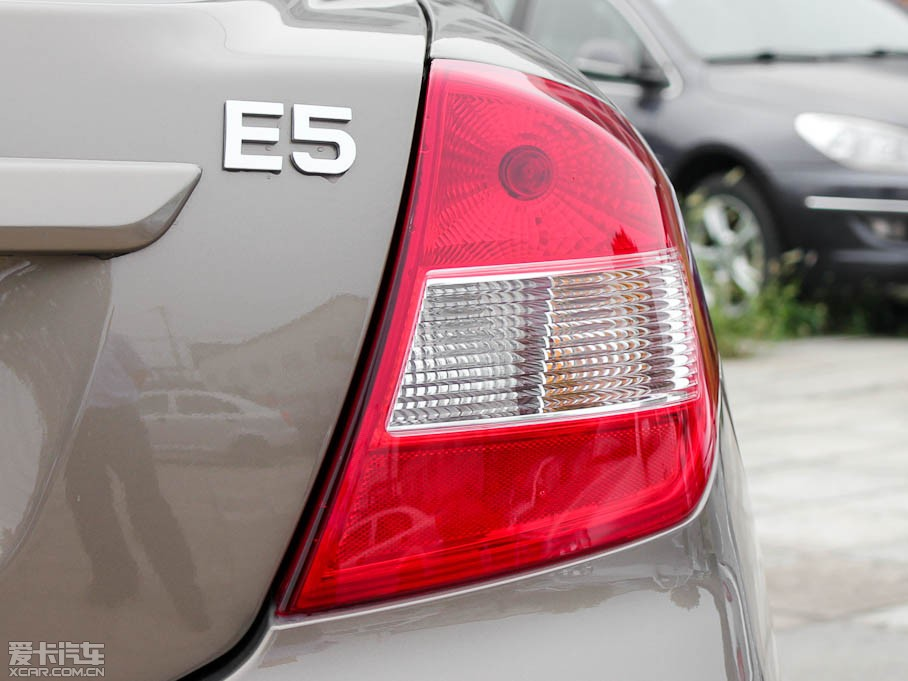

In [84]:
show_img(f"{car_parts_test}/taillights.jpg")

In [85]:
with dspy.context(lm=claude_haiku,rm=multi_modal_rm):
    rag = MultiModalRAG(QueryByImage,multi_modal_rm)
    image_path = f"{car_parts_test}/taillights.jpg"
    resp = rag(question="Is this a fog light?", image_path=image_path)
    print(resp.answer)

Prediction(
    answer='Based on the context provided, the image does not show a fog light, but rather a headlight assembly. The descriptions indicate that the images depict the sleek, modern headlight design of a Ford or other recent model vehicle, featuring a projector-beam style headlamp. There is no mention of a fog light in the context provided. Therefore, the answer to the question "Is this a fog light?" is no, this is not a fog light, but rather a headlight assembly.'
)


## DSPy module with image inputs
In this section, we will build a DSPy module with image as an input which will be sent as image payload to Claude 3 model. 

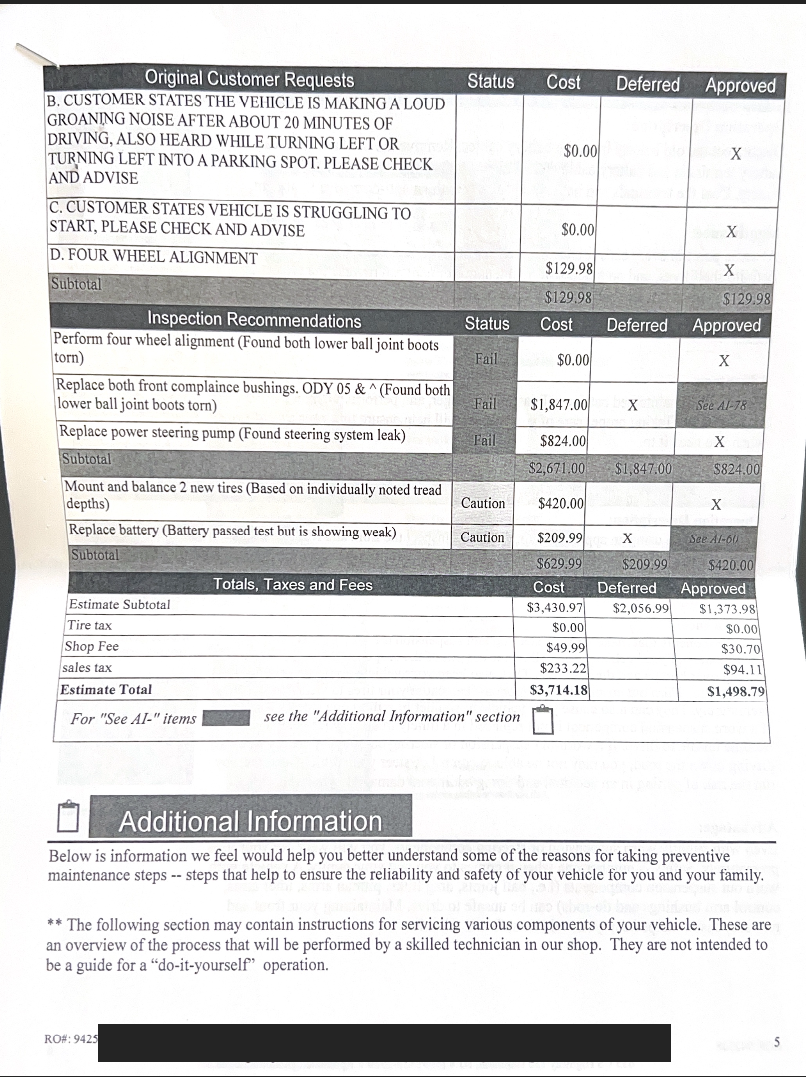

In [86]:
show_img("images/auto_repair_advice.png")

In [87]:
class ExtractItems(dspy.Signature):
    """Extracts information from an image"""
    extraction = dspy.InputField(desc="item to be extracted")
    image = dspy.InputField(desc="input image", format="png")
    items = dspy.OutputField(desc="list of items")
    
with dspy.context(lm=claude_sonnet_multimodal):
    image_path = "images/auto_repair_advice.png"
    img_ext,img = img2base64(image_path)
    simple_agent =PredictMultiModal(ExtractItems)
    resp = simple_agent(extraction="list original customer requests and their cost",image= img)
    print(resp)

Prediction(
    items='Based on the image, here are the original customer requests and their costs:\n\nItems:\n- B. CUSTOMER STATES THE VEHICLE IS MAKING A LOUD GROANING NOISE AFTER ABOUT 20 MINUTES OF DRIVING, ALSO HEARD WHILE TURNING LEFT OR TURNING LEFT INTO A PARKING SPOT. PLEASE CHECK AND ADVISE: Cost $0.00, Approved\n- C. CUSTOMER STATES VEHICLE IS STRUGGLING TO START, PLEASE CHECK AND ADVISE: Cost $0.00, Approved  \n- D. FOUR WHEEL ALIGNMENT: Cost $129.98, Approved'
)


## Inspect history
We can check the prompts sent to the LM with inspect_history

In [16]:
claude_haiku.inspect_history(n=1)

''

In [17]:
print(claude_sonnet.inspect_history(n=1))






Human: Respond to the question from the given context. Skip the preamble and rationale

---

Context: In 1974, the unmanned AstroFlight Sunrise plane made the first solar flight. On 29 April 1979, the Solar Riser made the first flight in a solar-powered, fully controlled, man carrying flying machine, reaching an altitude of 40 feet (12 m). In 1980, the Gossamer Penguin made the first piloted flights powered solely by photovoltaics. This was quickly followed by the Solar Challenger which crossed the English Channel in July 1981. In 1990 Eric Scott Raymond in 21 hops flew from California to North Carolina using solar power. Developments then turned back to unmanned aerial vehicles (UAV) with the Pathfinder (1997) and subsequent designs, culminating in the Helios which set the altitude record for a non-rocket-propelled aircraft at 29,524 metres (96,864 ft) in 2001. The Zephyr, developed by BAE Systems, is the latest in a line of record-breaking solar aircraft, making a 54-hour flight